In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 26/11/2021

    Code description :
    __________________
    Observe that the reconstruction is faster if we compensate for the multiplicities.
"""
import matplotlib.pyplot as plt
import numpy as np
import spgl1

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from graphics import show_rec2D

In [2]:
"Parameters"
N = 64 # vector size
K = 6 # sparsity
Q = 120 # Number of cores
M = 250 # Number of observations y

"Define the sparse object"
pos_x = np.random.randint(0, high=N, size=K)
pos_y = np.random.randint(0, high=N, size=K)
f = np.zeros((N,N))
for i in range(K):
    f[pos_x[i], pos_y[i]] = (-1)**i
f_flat = f.reshape(-1)

"Fermat spiral"
diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
# diam_endo = N
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_sources[0,:], pos_sources[0,:]).astype(int)
Om_y = np.subtract.outer(pos_sources[1,:], pos_sources[1,:]).astype(int)

"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity(Om_x, Om_y)

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core

In [3]:
SNR_target = 50
opt_tol = np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol)

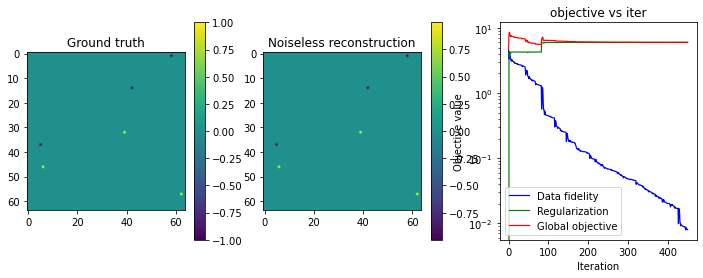

SNR: 50.27 dB


In [4]:
A_ROP = ROP_model2(Om_x, Om_y, a_ij, N)
A_ROP_r = Op2Real(A_ROP)
y_ROP_r = A_ROP_r@f_flat
recovery = bpalg(A_ROP_r, y_ROP_r)
x_ROP = recovery[0].reshape((N,N))
xnorm1 = recovery[3]["xnorm1"]
rnorm2 = recovery[3]["rnorm2"]
show_rec2D(f, x_ROP, np.array([rnorm2, xnorm1]).T, linewidth=1.2 )

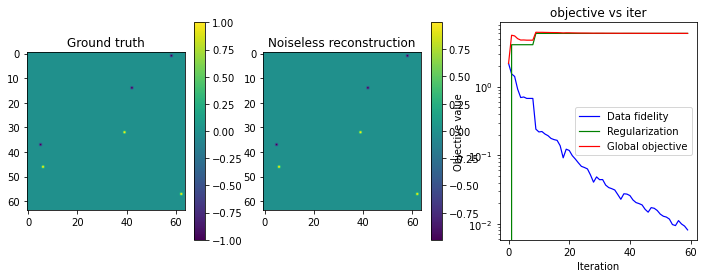

SNR: 45.24 dB


In [5]:
A_ROP = ROP_model2(Om_x, Om_y, a_ij, N, mult_mat=multiplicities)
A_ROP_r = Op2Real(A_ROP)
y_ROP_r = A_ROP_r@f_flat
recovery = bpalg(A_ROP_r, y_ROP_r)
x_ROP = recovery[0].reshape((N,N))
xnorm1 = recovery[3]["xnorm1"]
rnorm2 = recovery[3]["rnorm2"]
show_rec2D(f, x_ROP, np.array([rnorm2, xnorm1]).T, linewidth=1.2 )